In [1]:
import itertools
#import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report,accuracy_score
#from sklearn import preprocessing,cross_validation,neighbors
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from time import time
from sklearn.impute import SimpleImputer, KNNImputer
%matplotlib inline

In [5]:
dataset = pd.read_csv('breastcancer-wisconsin.data.txt')

dataset.replace('?', -999, inplace=True)

In [6]:
dataset.shape

(699, 11)

In [7]:
dataset.describe()

,Samplecodenumber,Clump-Thickness,UniformityCelSize,Uniformity-CelShape,Marginal-Adhesion,SingleEpithelialCelSize,Bland-Chromatin,Normal-Nucleol,Mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [8]:
dataset

,Samplecodenumber,Clump-Thickness,UniformityCelSize,Uniformity-CelShape,Marginal-Adhesion,SingleEpithelialCelSize,Bare Nuclei,Bland-Chromatin,Normal-Nucleol,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


# PREPROCESSING

In [ ]:
# to generat heat map with out samplecode number
dataset.drop(['Samplecodenumber'],1,inplace=True)
#X = dataset.iloc[:, 0:9].values
#Y = dataset.iloc[:, 9].values


In [10]:
for i in range(0,699):
    if dataset.iloc[i]["Bare Nuclei"]== -999:
         print (i,dataset.iloc[i]["Bare Nuclei"])

23 -999
40 -999
139 -999
145 -999
158 -999
164 -999
235 -999
249 -999
275 -999
292 -999
294 -999
297 -999
315 -999
321 -999
411 -999
617 -999


# Checking missing values in the suspected columns

In [13]:
import pandas as pd
import numpy as np

print((dataset[["Clump-Thickness","Uniformity-CelShape","Bare Nuclei"]] == -999).sum())
# checking missing values in suspected columns


Clump-Thickness         0
Uniformity-CelShape     0
Bare Nuclei            16
dtype: int64


# Checking the imputation methods MSE values, smaller is better

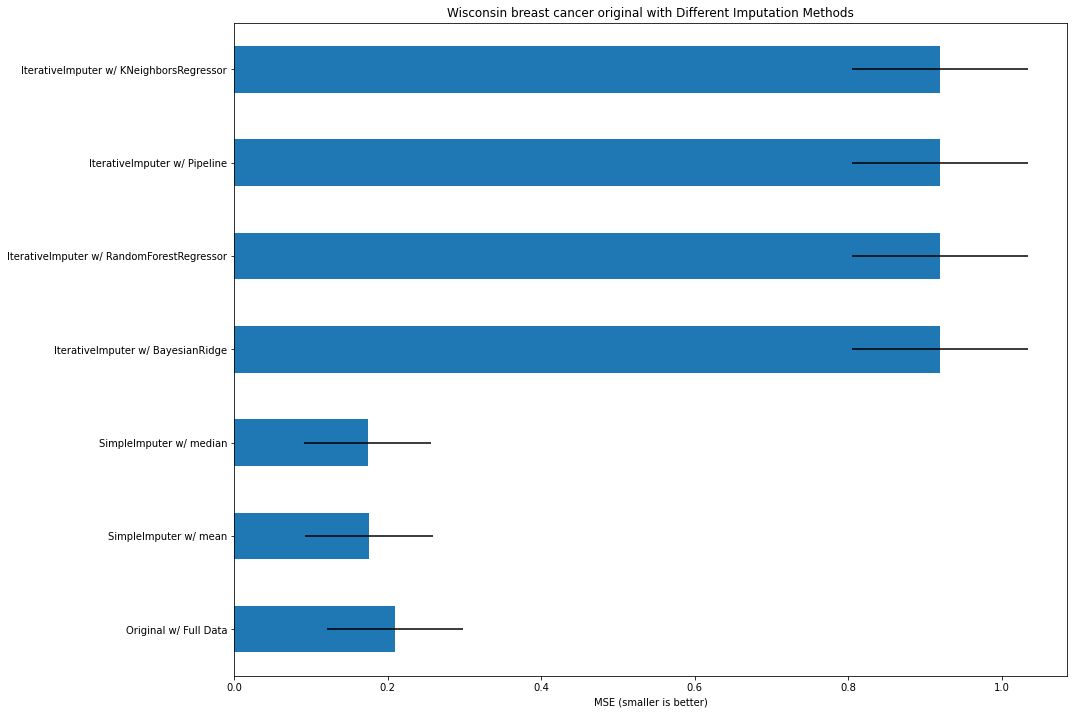

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5

rng = np.random.RandomState(0)

#X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.

X_full = dataset.iloc[:, 0:9].values
y_full = dataset.iloc[:, 9].values
#X_full = X_full[::10]
#y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = -999

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=-999, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=40,
        max_depth=17,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=19),
]
score_iterative_imputer = pd.DataFrame()
# iterative imputer is sensible to the tolerance and
# dependent on the estimator used internally.
# we tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot california housing results
fig, ax = plt.subplots(figsize=(15, 10))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("Wisconsin breast cancer original with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

# Handling with Missing values

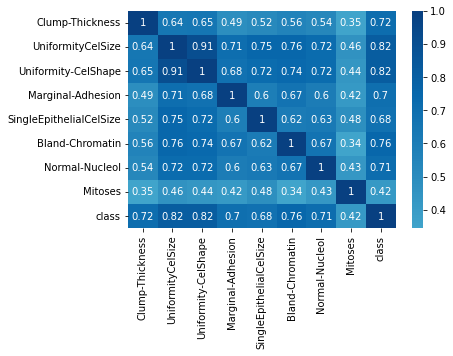

In [11]:
import seaborn as sns
sns.heatmap(dataset.corr(), center = 0, annot =True, cmap='GnBu');

<AxesSubplot:>

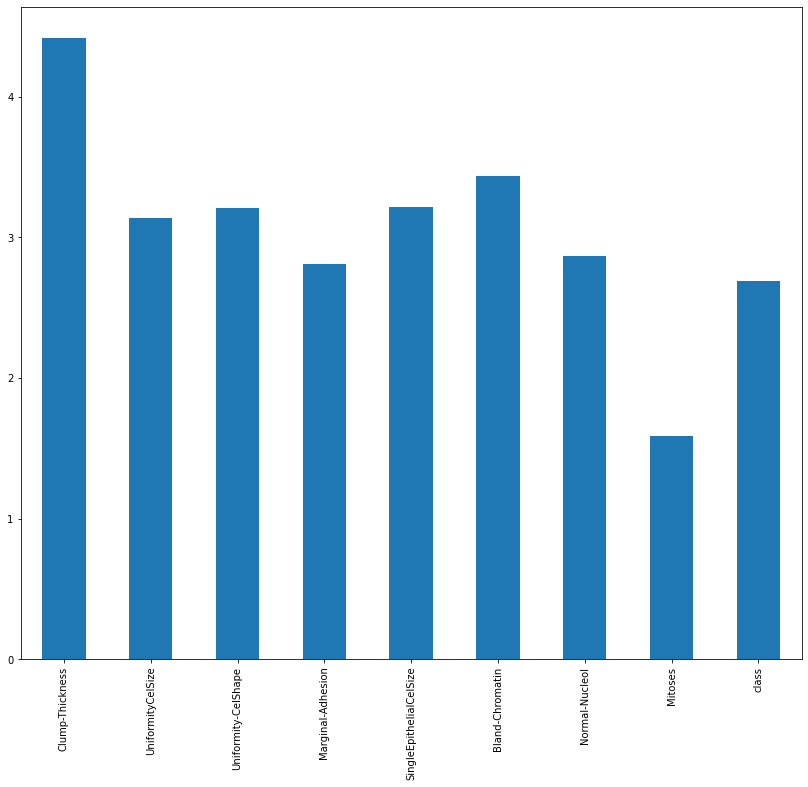

In [12]:
import seaborn as sns
dataset_mean = dataset.describe().loc['mean']
dataset_mean.plot(kind='bar', figsize=(14,12))

# DATASET VISUALIZATION

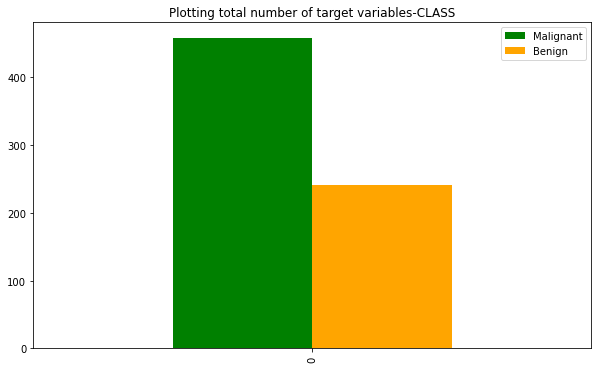

In [13]:
dataset_M = dataset[dataset['class'] == 2]
dataset_B = dataset[dataset['class'] == 4]
#dataset_HY = dataset[dataset['Class'] == 2]
B_M_data = {'Malignant': [dataset_M.shape[0]], 'Benign': [dataset_B.shape[0]]}
B_M_df = pd.DataFrame(data=B_M_data)
B_M_df.plot(kind='bar', figsize=(10,6), color=['green','orange'])
plt.title(f"Plotting total number of target variables-CLASS")
plt.show()

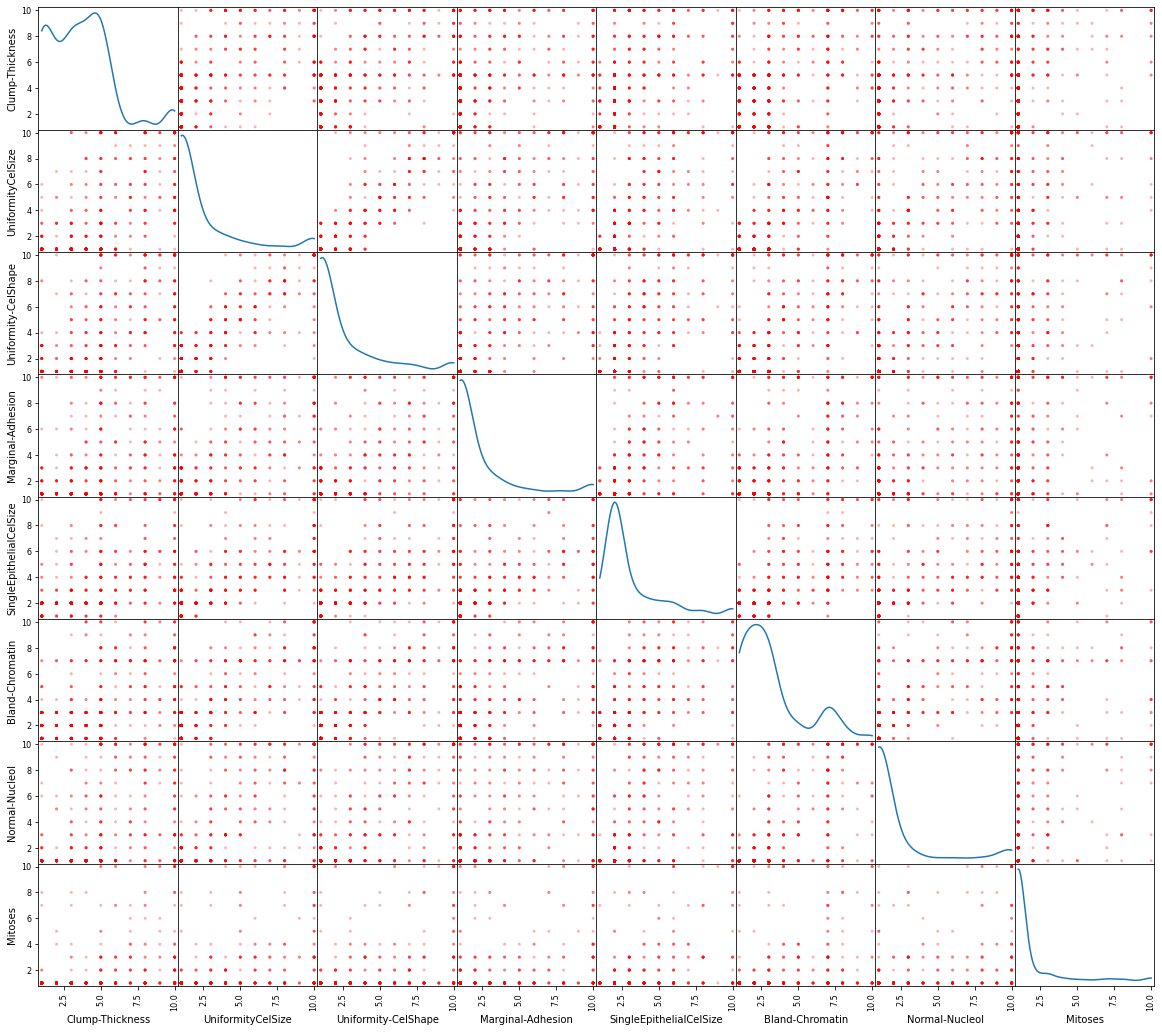

In [14]:
classs = dataset['class']
features = dataset.drop(['class'], axis = 1)
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (20,18), diagonal = 'kde', c='red');

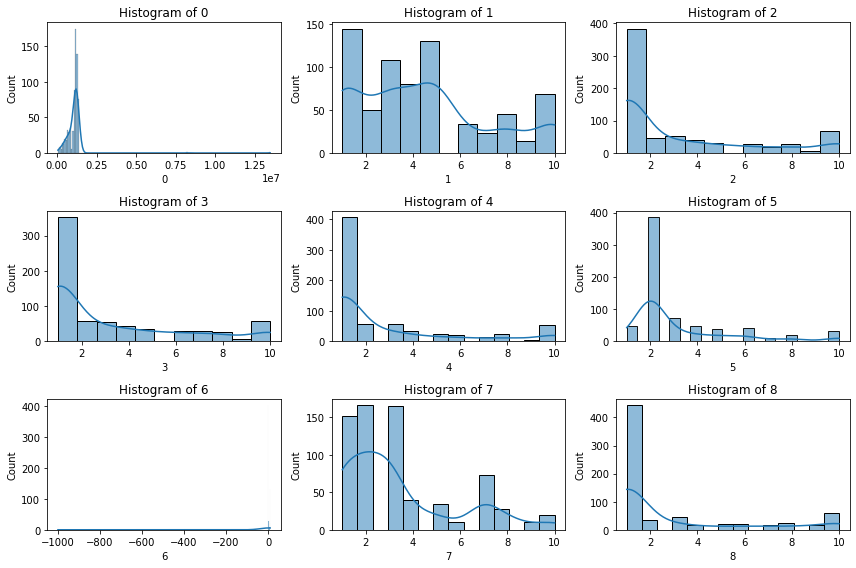

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Load dataset
dataset = pd.read_csv('breastcancer-wisconsin.data.txt')
dataset.replace('?', -999, inplace=True)

# Splitting features and target
X_full = dataset.iloc[:, 0:9].values
y_full = dataset.iloc[:, 9].values

# Handling missing values by replacing them with the median (for simplicity)
X_full = pd.DataFrame(X_full)
X_full = X_full.apply(pd.to_numeric, errors='coerce')  # Convert to numeric (handle non-numeric values)
#X_full.fillna(X_full.median(), inplace=True)  # Fill missing values with median

# 1. Histograms (distribution of features)
plt.figure(figsize=(12, 8))
for i, feature in enumerate(X_full.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_full[feature], kde=True)
    plt.title(f"Histogram of {feature}")
plt.tight_layout()
plt.show()

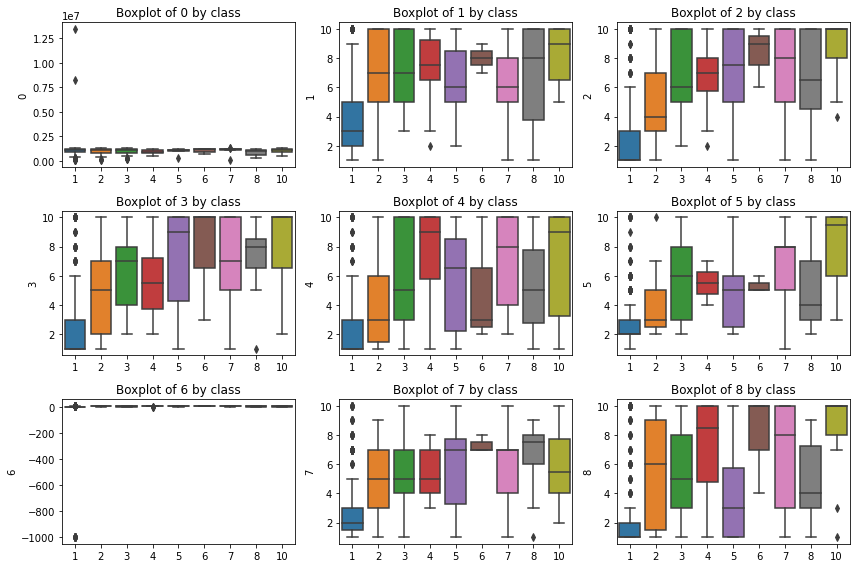

In [16]:
# 2. Box plots (checking outliers)
plt.figure(figsize=(12, 8))
for i, feature in enumerate(X_full.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=y_full, y=X_full[feature])
    plt.title(f"Boxplot of {feature} by class")
plt.tight_layout()
plt.show()

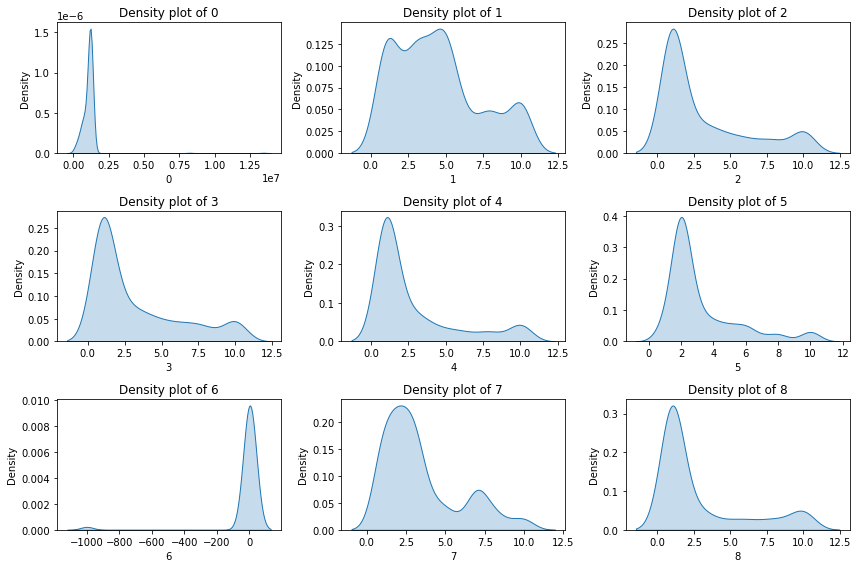

In [17]:
# 9. Density plots (Kernel Density Estimate)
plt.figure(figsize=(12, 8))
for i, feature in enumerate(X_full.columns):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(X_full[feature], shade=True)
    plt.title(f"Density plot of {feature}")
plt.tight_layout()
plt.show()

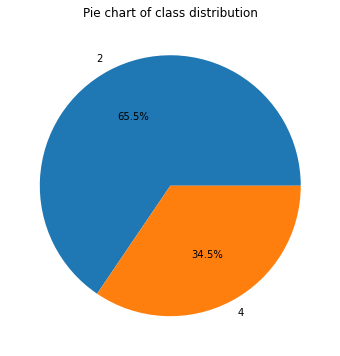

In [18]:
# 10. Pie chart (categorical distribution)
dataset['class'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6))
plt.title("Pie chart of class distribution")
plt.ylabel('')
plt.show()


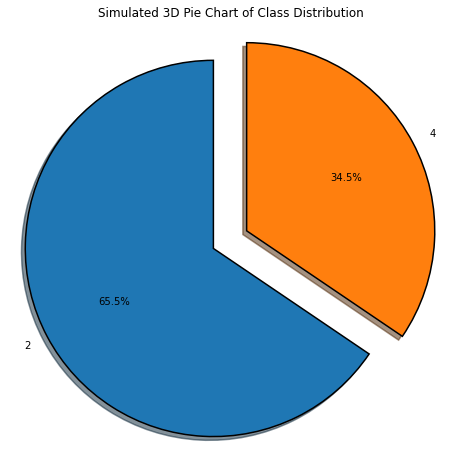

In [19]:
import matplotlib.pyplot as plt
import numpy as np



# Getting value counts of the target variable
counts = dataset['class'].value_counts()

# Creating the pie chart with enhanced 3D-like effects
fig, ax = plt.subplots(figsize=(8, 8))

# Data for the pie chart
labels = counts.index
sizes = counts.values
explode = [0.1] * len(labels)  # Exploding the slices for better visuals

# Plotting the pie chart
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode, 
                                  startangle=90, shadow=True, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})

# Adding 3D-like effect with a shadow and setting the angle for a dynamic appearance
for wedge in wedges:
    wedge.set_linewidth(1.5)
    wedge.set_edgecolor('black')

# Customizing the appearance of the plot
ax.set_title("Simulated 3D Pie Chart of Class Distribution")
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()




In [20]:
dataset[23: 24]

,Samplecodenumber,Clump-Thickness,UniformityCelSize,Uniformity-CelShape,Marginal-Adhesion,SingleEpithelialCelSize,Bare Nuclei,Bland-Chromatin,Normal-Nucleol,Mitoses,class
23,1057013,8,4,5,1,2,-999,7,3,1,4


In [21]:
# to generat heat map with out samplecode number
dataset.drop(['Samplecodenumber'],1,inplace=True)

C:\Users\Zohaib\AppData\Local\Temp\ipykernel_1580\1015787863.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset.drop(['Samplecodenumber'],1,inplace=True)


In [22]:
dataset=dataset.replace({'class':{2:0, 4:1}})

# mean imputation 

In [23]:
mean_imputer = SimpleImputer(missing_values= -999, strategy='mean')# fill missing values from imputter, which uses means
mean_imputer = mean_imputer.fit(dataset)
imputed_dataset1 = mean_imputer.transform(dataset.values)

C:\Users\Zohaib\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [24]:
print(imputed_dataset1 [23][5])

3.5446559297218156


In [25]:
imputed_dataset1[23: 24]

array([[8.        , 4.        , 5.        , 1.        , 2.        ,
        3.54465593, 7.        , 3.        , 1.        , 1.        ]])

In [26]:
Xil= imputed_dataset1[:,0:9]# initializing XI AND YI to the new imputed_dataset1, which dont have missing values
Yil= imputed_dataset1[:,9]
print(Xil)
Xil.shape

[[ 5.  1.  1. ...  3.  1.  1.]
 [ 5.  4.  4. ...  3.  2.  1.]
 [ 3.  1.  1. ...  3.  1.  1.]
 ...
 [ 5. 10. 10. ...  8. 10.  2.]
 [ 4.  8.  6. ... 10.  6.  1.]
 [ 4.  8.  8. ... 10.  4.  1.]]


(699, 9)

In [27]:
Yil

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0.

# Factor Analysis 2D and 3D visualization

Text(0.5, 1.0, 'Factor Analysis with two components p1 vs p2 with MinMax scaling ')

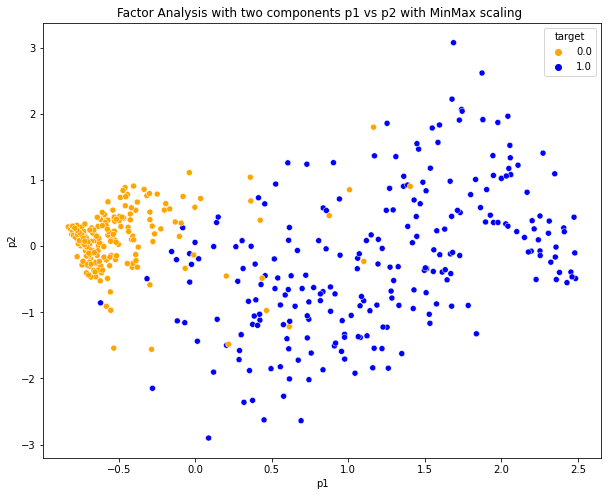

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(Xil)

fa = FactorAnalysis(n_components=2, random_state=42)
fa.fit(x_scaled)
X_reduced_fa = fa.transform(x_scaled)
fa_data = pd.DataFrame(X_reduced_fa, columns=["p1", "p2"])
fa_data["target"] = Yil
plt.figure(figsize=(10,8))

sns.scatterplot(x="p1", y="p2" , hue="target", data=fa_data,palette=['orange','blue'], legend='full')

plt.title("Factor Analysis with two components p1 vs p2 with MinMax scaling ")

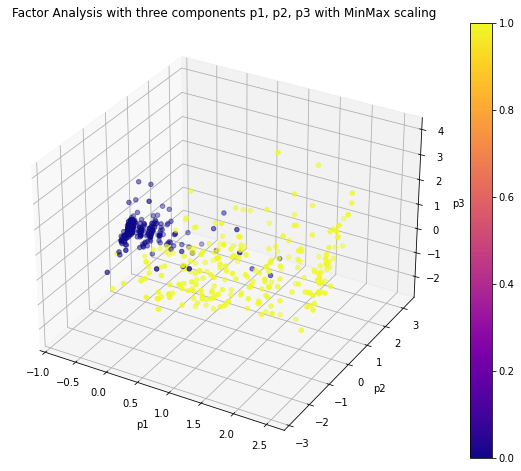

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Assuming Xil and Yil are defined earlier in your code
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(Xil)

fa = FactorAnalysis(n_components=3, random_state=42)  # Set components to 3 for 3D
fa.fit(x_scaled)
X_reduced_fa = fa.transform(x_scaled)
fa_data = pd.DataFrame(X_reduced_fa, columns=["p1", "p2", "p3"])
fa_data["target"] = Yil

# Creating a 3D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(fa_data["p1"], fa_data["p2"], fa_data["p3"], c=fa_data["target"], cmap='plasma')

# Adding labels
ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_zlabel('p3')
ax.set_title("Factor Analysis with three components p1, p2, p3 with MinMax scaling")

# Show color bar
plt.colorbar(scatter)

plt.show()


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced_fa, Yil, test_size = 0.2)

In [31]:
from sklearn.ensemble import RandomForestClassifier
import time
#tic = time()

start = time.time()
clf1 = RandomForestClassifier(criterion='gini', max_depth=10, random_state=123)

#t0=time()
#print("training time:", round(time()-t0, 3), "s")
clf1.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")


start1 = time.time()
RF=clf1.predict(X_test)
stop1 = time.time()
print(f"Predicting time: {stop1 - start1}s")
#toc = time()
#t1=time()
#print("Predicting time:", round(time()-t0, 3), "s")
accRF=clf1.score(X_test,Y_test)

print(accRF,'Random Forest')
print(classification_report(Y_test,RF))

Training time: 0.5361759662628174s
Predicting time: 0.06962871551513672s
0.9785714285714285 Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        89
         1.0       0.94      1.00      0.97        51

    accuracy                           0.98       140
   macro avg       0.97      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



In [32]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import zero_one_loss



Cohen_kappa = cohen_kappa_score(Y_test,RF) 
print(" Cohen_kappa:", Cohen_kappa)

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming Y_test are the true labels and RF are the predicted labels
precision = precision_score(Y_test, RF)
recall = recall_score(Y_test, RF)
f1 = f1_score(Y_test, RF)

# Display the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



MCC = matthews_corrcoef(Y_test,RF)
print('MCC:', MCC)


 Cohen_kappa: 0.9543080939947781
Precision: 0.9444444444444444
Recall: 1.0
F1 Score: 0.9714285714285714
MCC: 0.9553058350350087


Confusion matrix, without normalization
[[86  3]
 [ 0 51]]


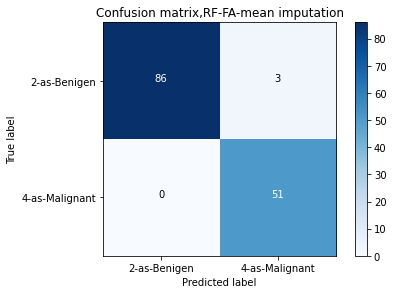

Normalized confusion matrix
[[0.97 0.03]
 [0.   1.  ]]


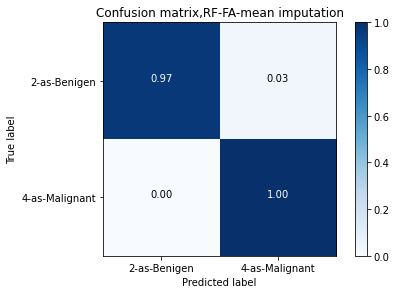

In [33]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues, fontsize= 40):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
  else:
       print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cn_matrix = confusion_matrix(Y_test, RF)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=False,
                     title='Confusion matrix,RF-FA-mean imputation',fontsize=40)
plt.show()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=True,
                     title='Confusion matrix,RF-FA-mean imputation',fontsize=40)
plt.show()

Confusion matrix, without normalization
[[86  3]
 [ 0 51]]


<Figure size 432x288 with 0 Axes>

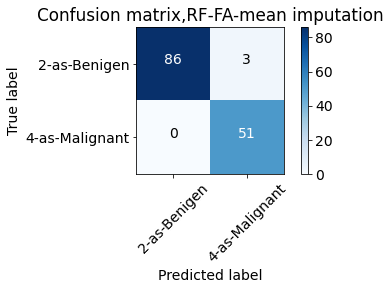

Normalized confusion matrix
[[0.97 0.03]
 [0.   1.  ]]


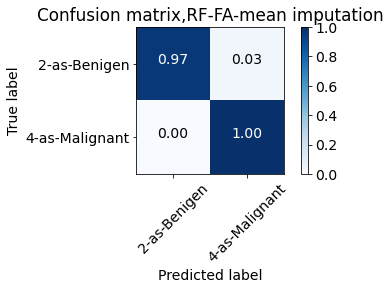

In [34]:
import itertools
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
  else:
       print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


from sklearn.metrics import confusion_matrix
cn_matrix = confusion_matrix(Y_test, RF)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 14})
plt.figure()

plt.figure()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=False,
                     title='Confusion matrix,RF-FA-mean imputation')
plt.show()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=True,
                     title='Confusion matrix,RF-FA-mean imputation')
plt.show()

# PCA Based results

Text(0.5, 1.0, 'WBC data PCA=2: PC1 vs PC2 ')

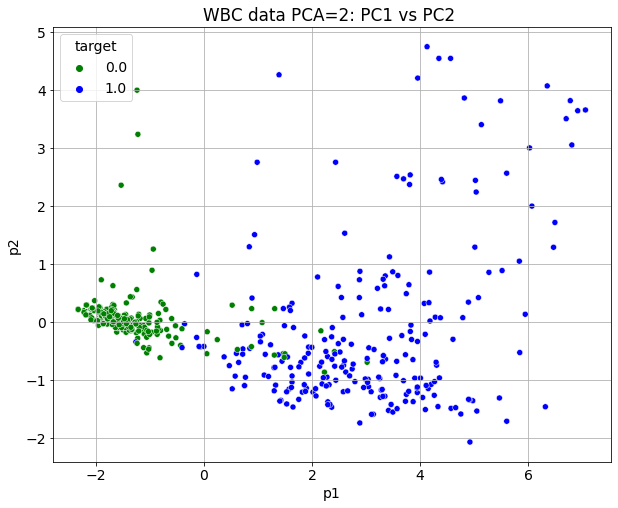

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
sc = MinMaxScaler()
x_scaled = scaler.fit_transform(Xil)

pca = PCA(n_components=2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns=["p1", "p2"])
pca_data["target"] = Yil
plt.figure(figsize=(10,8))

sns.scatterplot(x="p1", y="p2" , hue="target", data=pca_data,palette=['green','blue'], legend='full')
plt.grid()
plt.title("WBC data PCA=2: PC1 vs PC2 ")

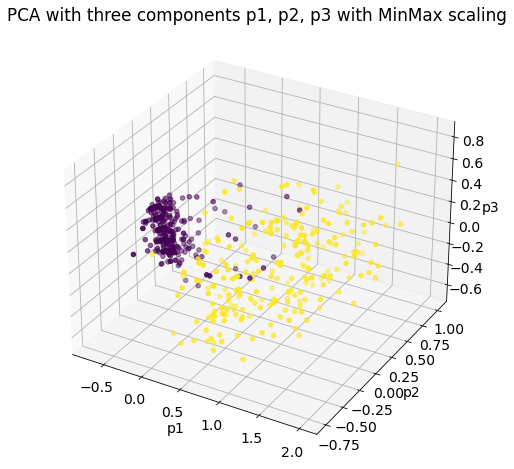

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Assuming Xil and Yil are defined earlier in your code
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(Xil)

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3, random_state=42)  # Set components to 3 for 3D projection
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)  # Transform data into 3D

# Create a DataFrame for the reduced PCA components and add the target labels
pca_data = pd.DataFrame(X_reduced_pca, columns=["p1", "p2", "p3"])
pca_data["target"] = Yil

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D with color based on target class
scatter = ax.scatter(pca_data["p1"], pca_data["p2"], pca_data["p3"], c=pca_data["target"], cmap='viridis')

# Adding axis labels and title
ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_zlabel('p3')
ax.set_title("PCA with three components p1, p2, p3 with MinMax scaling")

# Show the plot
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced_pca, Yil, test_size = 0.2)

In [38]:
from sklearn.ensemble import RandomForestClassifier
import time
#tic = time()

start = time.time()
clf2 = RandomForestClassifier(criterion='gini', max_depth=10, random_state=123)

#t0=time()
#print("training time:", round(time()-t0, 3), "s")
clf2.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")


start1 = time.time()
RF2=clf2.predict(X_test)
stop1 = time.time()
print(f"Predicting time: {stop1 - start1}s")
#toc = time()
#t1=time()
#print("Predicting time:", round(time()-t0, 3), "s")
accRF=clf2.score(X_test,Y_test)

print(accRF,'Random Forest')
print(classification_report(Y_test,RF2))

Training time: 0.5038027763366699s
Predicting time: 0.05066561698913574s
0.95 Random Forest
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96        93
         1.0       0.90      0.96      0.93        47

    accuracy                           0.95       140
   macro avg       0.94      0.95      0.94       140
weighted avg       0.95      0.95      0.95       140



In [39]:

Cohen_kappa = cohen_kappa_score(Y_test,RF2) 
print(" Cohen_kappa:", Cohen_kappa)

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming Y_test are the true labels and RF are the predicted labels
precision = precision_score(Y_test, RF2)
recall = recall_score(Y_test, RF2)
f1 = f1_score(Y_test, RF2)

# Display the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


MCC = matthews_corrcoef(Y_test,RF2)
print('MCC:', MCC)

 Cohen_kappa: 0.8896396396396397
Precision: 0.9
Recall: 0.9574468085106383
F1 Score: 0.9278350515463918
MCC: 0.8906363894827827


Confusion matrix, without normalization
[[88  5]
 [ 2 45]]


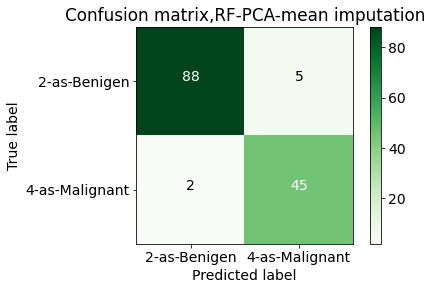

Normalized confusion matrix
[[0.95 0.05]
 [0.04 0.96]]


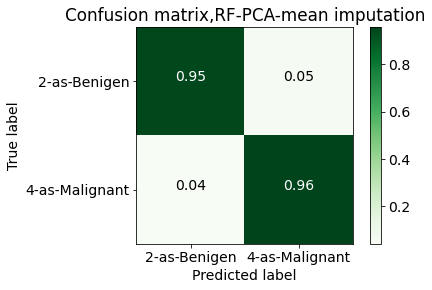

In [40]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Greens):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
  else:
       print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cn_matrix = confusion_matrix(Y_test, RF2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=False,
                     title='Confusion matrix,RF-PCA-mean imputation')
plt.show()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=True,
                     title='Confusion matrix,RF-PCA-mean imputation')
plt.show()

In [41]:
# Feature scaling

# Feature Selection WITH OUT Dimensionality Reduction

# CHI2 FS

In [42]:
X_n = SelectKBest(chi2, k=6).fit_transform(x_scaled, Yil)
X_n.shape

(699, 6)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Yil, test_size = 0.2)

In [44]:
from sklearn.ensemble import RandomForestClassifier
import time
#tic = time()

start = time.time()
clf3 = RandomForestClassifier(criterion='gini', max_depth=10, random_state=123)

#t0=time()
#print("training time:", round(time()-t0, 3), "s")
clf3.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")


start1 = time.time()
RF3=clf3.predict(X_test)
stop1 = time.time()
print(f"Predicting time: {stop1 - start1}s")
#toc = time()
#t1=time()
#print("Predicting time:", round(time()-t0, 3), "s")
accRF=clf3.score(X_test,Y_test)

print(accRF,'Random Forest')
print(classification_report(Y_test,RF3))

Training time: 0.6780028343200684s
Predicting time: 0.04008936882019043s
0.95 Random Forest
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96        95
         1.0       0.91      0.93      0.92        45

    accuracy                           0.95       140
   macro avg       0.94      0.95      0.94       140
weighted avg       0.95      0.95      0.95       140



In [45]:

Cohen_kappa = cohen_kappa_score(Y_test,RF3) 
print(" Cohen_kappa:", Cohen_kappa)

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming Y_test are the true labels and RF are the predicted labels
precision = precision_score(Y_test, RF3)
recall = recall_score(Y_test, RF3)
f1 = f1_score(Y_test, RF3)

# Display the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


MCC = matthews_corrcoef(Y_test,RF3)
print('MCC:', MCC)

 Cohen_kappa: 0.886046511627907
Precision: 0.9130434782608695
Recall: 0.9333333333333333
F1 Score: 0.9230769230769231
MCC: 0.886163939724785


Confusion matrix, without normalization
[[91  4]
 [ 3 42]]


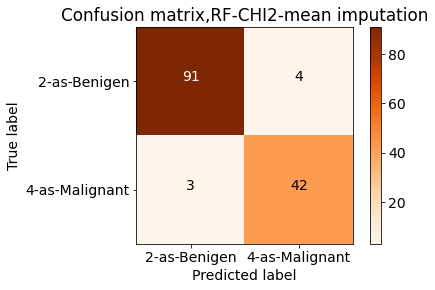

Normalized confusion matrix
[[0.96 0.04]
 [0.07 0.93]]


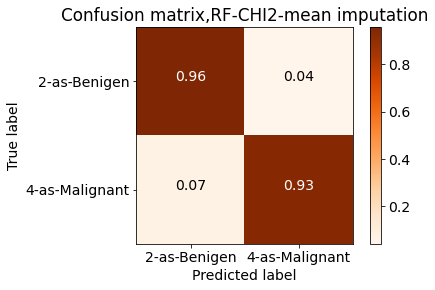

In [46]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Oranges):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
  else:
       print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cn_matrix = confusion_matrix(Y_test, RF3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=False,
                     title='Confusion matrix,RF-CHI2-mean imputation')
plt.show()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=True,
                     title='Confusion matrix,RF-CHI2-mean imputation')
plt.show()

# Recurrsive Feature Elimination

In [47]:
from sklearn.svm import LinearSVC, SVR
from sklearn.feature_selection import RFE
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=7)
selector = selector.fit(x_scaled, Yil)

In [48]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(Xil)  # Make sure x_scaled is 2D (shape: [n_samples, n_features])

# Define the estimator for RFE (Support Vector Regression with a linear kernel)
estimator = SVR(kernel="linear")

# Initialize the RFE selector with the estimator and number of features to select
selector = RFE(estimator, n_features_to_select=7)  # Adjust the number as needed (e.g., 7 features)

# Fit the RFE selector to the scaled data
selector.fit(x_scaled, Yil)

RFE(estimator=SVR(kernel='linear'), n_features_to_select=7)

In [49]:
# Define the estimator for RFE (Support Vector Regression with a linear kernel)
estimator = SVR(kernel="linear")

# Initialize the RFE selector with the estimator and number of features to select
selector = RFE(estimator, n_features_to_select=7)  # Adjust the number as needed (e.g., 7 features)

# Fit the RFE selector to the scaled data
selector.fit(x_scaled, Yil)

# Get the selected features (True means the feature was selected)
selected_features = selector.support_  
print("Selected features:", selected_features)

# Prepare the data with the selected features (extract the selected columns from the original scaled data)
x_selected = x_scaled[:, selected_features]

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(x_selected, Yil, test_size=0.2, random_state=42)



Selected features: [ True  True  True False  True  True  True  True False]


In [50]:


from sklearn.ensemble import RandomForestClassifier
import time
#tic = time()

start = time.time()
clf4 = RandomForestClassifier(criterion='gini', max_depth=10, random_state=123)

#t0=time()
#print("training time:", round(time()-t0, 3), "s")
clf4.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")


start1 = time.time()
RF4=clf4.predict(X_test)
stop1 = time.time()
print(f"Predicting time: {stop1 - start1}s")
#toc = time()
#t1=time()
#print("Predicting time:", round(time()-t0, 3), "s")
accRF=clf4.score(X_test,Y_test)

print(accRF,'Random Forest')
print(classification_report(Y_test,RF4))

Training time: 0.4863903522491455s
Predicting time: 0.044596195220947266s
0.9785714285714285 Random Forest
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98        95
         1.0       0.96      0.98      0.97        45

    accuracy                           0.98       140
   macro avg       0.97      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



In [51]:

Cohen_kappa = cohen_kappa_score(Y_test,RF4) 
print(" Cohen_kappa:", Cohen_kappa)

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming Y_test are the true labels and RF are the predicted labels
precision = precision_score(Y_test, RF4)
recall = recall_score(Y_test, RF4)
f1 = f1_score(Y_test, RF4)

# Display the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


MCC = matthews_corrcoef(Y_test,RF4)
print('MCC:', MCC)

 Cohen_kappa: 0.9511627906976744
Precision: 0.9565217391304348
Recall: 0.9777777777777777
F1 Score: 0.967032967032967
MCC: 0.9512888486809372


Confusion matrix, without normalization
[[93  2]
 [ 1 44]]


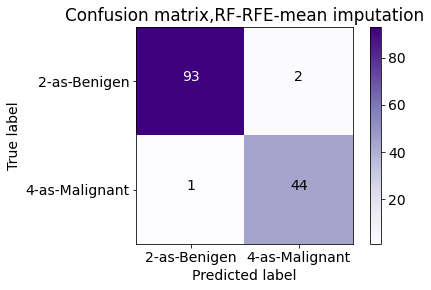

Normalized confusion matrix
[[0.98 0.02]
 [0.02 0.98]]


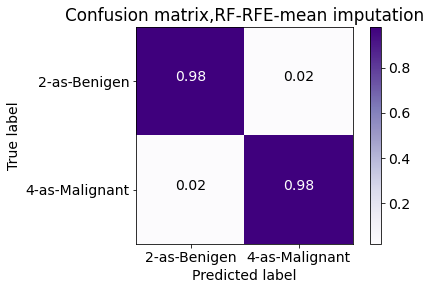

In [52]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Purples):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
  else:
       print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cn_matrix = confusion_matrix(Y_test, RF4)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=False,
                     title='Confusion matrix,RF-RFE-mean imputation')
plt.show()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=True,
                     title='Confusion matrix,RF-RFE-mean imputation')
plt.show()

# COMBINATION OF PCA with RFE

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Example dataset (replace with your dataset)
# Xil = your feature matrix
# Yil = your target vector

# Step 1: Scale the data using StandardScaler and MinMaxScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(Xil)

# Step 2: Apply PCA (reduce the number of components)
pca = PCA(n_components=2)  # You can adjust n_components based on your needs
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns=["p1", "p2"])
pca_data["target"] = Yil



# Step 3: Apply RFE to the PCA-transformed data
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=7)  # Adjust the number of features you want to select
selector.fit(X_reduced_pca, Yil)


# Prepare the data with the selected features (select only the columns of the selected features)
x_selected = X_reduced_pca[:, selected_features]

# Step 4: Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(x_selected, Yil, test_size=0.2, random_state=123)

# Step 5: Train a Random Forest Classifier on the selected features
rf_classifier = RandomForestClassifier(n_estimators=100,criterion='gini', max_depth=17, random_state=123)
rf_classifier.fit(X_train, Y_train)

# Step 6: Make predictions
Y_pred = rf_classifier.predict(X_test)

# Step 8: Evaluate the model using accuracy score and confusion matrix
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy of Random Forest Classifier on selected features: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)



IndexError: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 9

In [54]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming Xil and Yil are defined

# Step 1: Scale the data using StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(Xil)

# Step 2: Apply PCA (increase the number of components)
pca = PCA(n_components=5)  # Increased to 5 components
X_reduced_pca = pca.fit_transform(x_scaled)

# Visualize explained variance ratio (optional)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Step 3: Apply RFE to the PCA-transformed data
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5)  # Select 5 features
selector.fit(X_reduced_pca, Yil)

# Get the selected features
selected_features = selector.support_  # This is a boolean array
print("Selected features:", selected_features)

# Prepare the data with the selected features
x_selected = X_reduced_pca[:, selected_features]

# Step 4: Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(x_selected, Yil, test_size=0.2, random_state=123)

# Step 5: Train a Random Forest Classifier on the selected features
# Tune the hyperparameters using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=123)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

# Best parameters found from grid search
print(f"Best parameters: {grid_search.best_params_}")

# Use the best estimator from the grid search
best_rf_classifier = grid_search.best_estimator_

# Step 6: Make predictions
Y_pred = best_rf_classifier.predict(X_test)

# Step 7: Evaluate the model using accuracy score and confusion matrix
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy of Random Forest Classifier on selected features: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)


Explained variance ratio: [0.65 0.09 0.06 0.05 0.04]
Selected features: [ True  True  True  True  True]
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy of Random Forest Classifier on selected features: 0.9857
Confusion Matrix:
[[84  1]
 [ 1 54]]


In [56]:

from sklearn.ensemble import RandomForestClassifier
import time
#tic = time()

start = time.time()
#clf4 = RandomForestClassifier(criterion='gini', max_depth=10, random_state=123)

#t0=time()
#print("training time:", round(time()-t0, 3), "s")
best_rf_classifier.fit(X_train, Y_train)
stop = time.time()
print(f"Training time: {stop - start}s")


start1 = time.time()
RF5=best_rf_classifier.predict(X_test)
stop1 = time.time()
print(f"Predicting time: {stop1 - start1}s")
#toc = time()
#t1=time()
#print("Predicting time:", round(time()-t0, 3), "s")
accRF=best_rf_classifier.score(X_test,Y_test)

print(accRF,'Random Forest')
print(classification_report(Y_test,RF5))

Training time: 0.3770899772644043s
Predicting time: 0.01880335807800293s
0.9857142857142858 Random Forest
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        85
         1.0       0.98      0.98      0.98        55

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



In [57]:

Cohen_kappa = cohen_kappa_score(Y_test,RF5) 
print(" Cohen_kappa:", Cohen_kappa)

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming Y_test are the true labels and RF are the predicted labels
precision = precision_score(Y_test, RF5)
recall = recall_score(Y_test, RF5)
f1 = f1_score(Y_test, RF5)

# Display the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


MCC = matthews_corrcoef(Y_test,RF5)
print('MCC:', MCC)

 Cohen_kappa: 0.9700534759358289
Precision: 0.9818181818181818
Recall: 0.9818181818181818
F1 Score: 0.9818181818181818
MCC: 0.9700534759358289


Confusion matrix, without normalization
[[84  1]
 [ 1 54]]


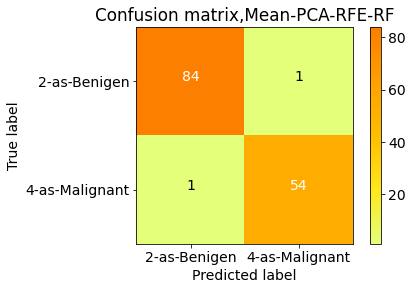

Normalized confusion matrix
[[0.99 0.01]
 [0.02 0.98]]


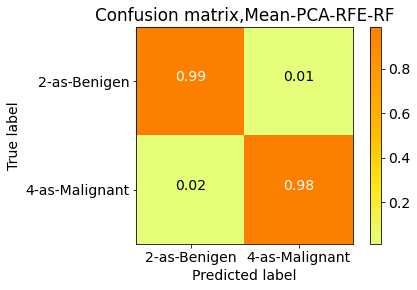

In [58]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Wistia):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
  else:
       print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cn_matrix = confusion_matrix(Y_test, RF5)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=False,
                     title='Confusion matrix,Mean-PCA-RFE-RF')
plt.show()
classs=['2-as-Benigen','4-as-Malignant']
plot_confusion_matrix(cn_matrix, classes=classs,normalize=True,
                     title='Confusion matrix,Mean-PCA-RFE-RF')
plt.show()